### Approximating the integral

It is easy to see that as we use large $n$ (i.e., more qubits) and thus larger $b_{\mbox{max}}$, we can approximate the integral better as illustrated below. 

In [1]:
import math

b_max = math.pi / 1000  # upper limit of integral # 5
nbit = 20  # change this value to get discretized result closer to analytical results # 3

analyticResult = (b_max / 2.0 - math.sin(2 * b_max) / 4.0 ) / b_max  # the target integral can be analytically solved
print("Analytical Result:", analyticResult)

ndiv = 2**nbit  #number of discretization 
discretizedResult = 0.0
for i in range(ndiv):
    discretizedResult += math.sin(b_max / ndiv * (i + 0.5))**2
discretizedResult = discretizedResult / ndiv
print("Discretized Result:", discretizedResult)

Analytical Result: 3.289861639787202e-06
Discretized Result: 3.289861639762322e-06


### Grover Operators for Amplitude Estimation

We can easily build quantum circuits for fast computation of the Monte Carlo integration as below. Here, we show functions to construct quantum circuits running with simulators. Running them on real devices should be easy by adjusting the parameters of the functions.  

In [2]:
import sys
sys.path.append('../libmitigation')

In [3]:
#Preparing qiskit environment
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import IBMQ
from qiskit import Aer
from scipy import optimize
import sys, time
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)


In [4]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import depolarizing_error
import qiskit.ignis.mitigation as mit
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
import importlib
from inv_sgs import InvSGS
from inv_s_sgs import InvSSGS
from inv_lm_sgs import InvLMSGS
from inv_s_lm_sgs import InvSLMSGS
from inv_s_lm0_sgs import InvSLM0SGS
from inv_s_lmk_sgs import InvSLMkSGS
from mooney_etal import MooneyEtal
from sgs_algorithm import sgs_algorithm
from lib_grover import *

For example, quantum circuit with two Grover operators is shown below.

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/visualization/matplotlib.py:291: DeprecationWarning: style option/s (usepiformat, cregbundle, compress) is/are not supported
  set_style(current_style, style)


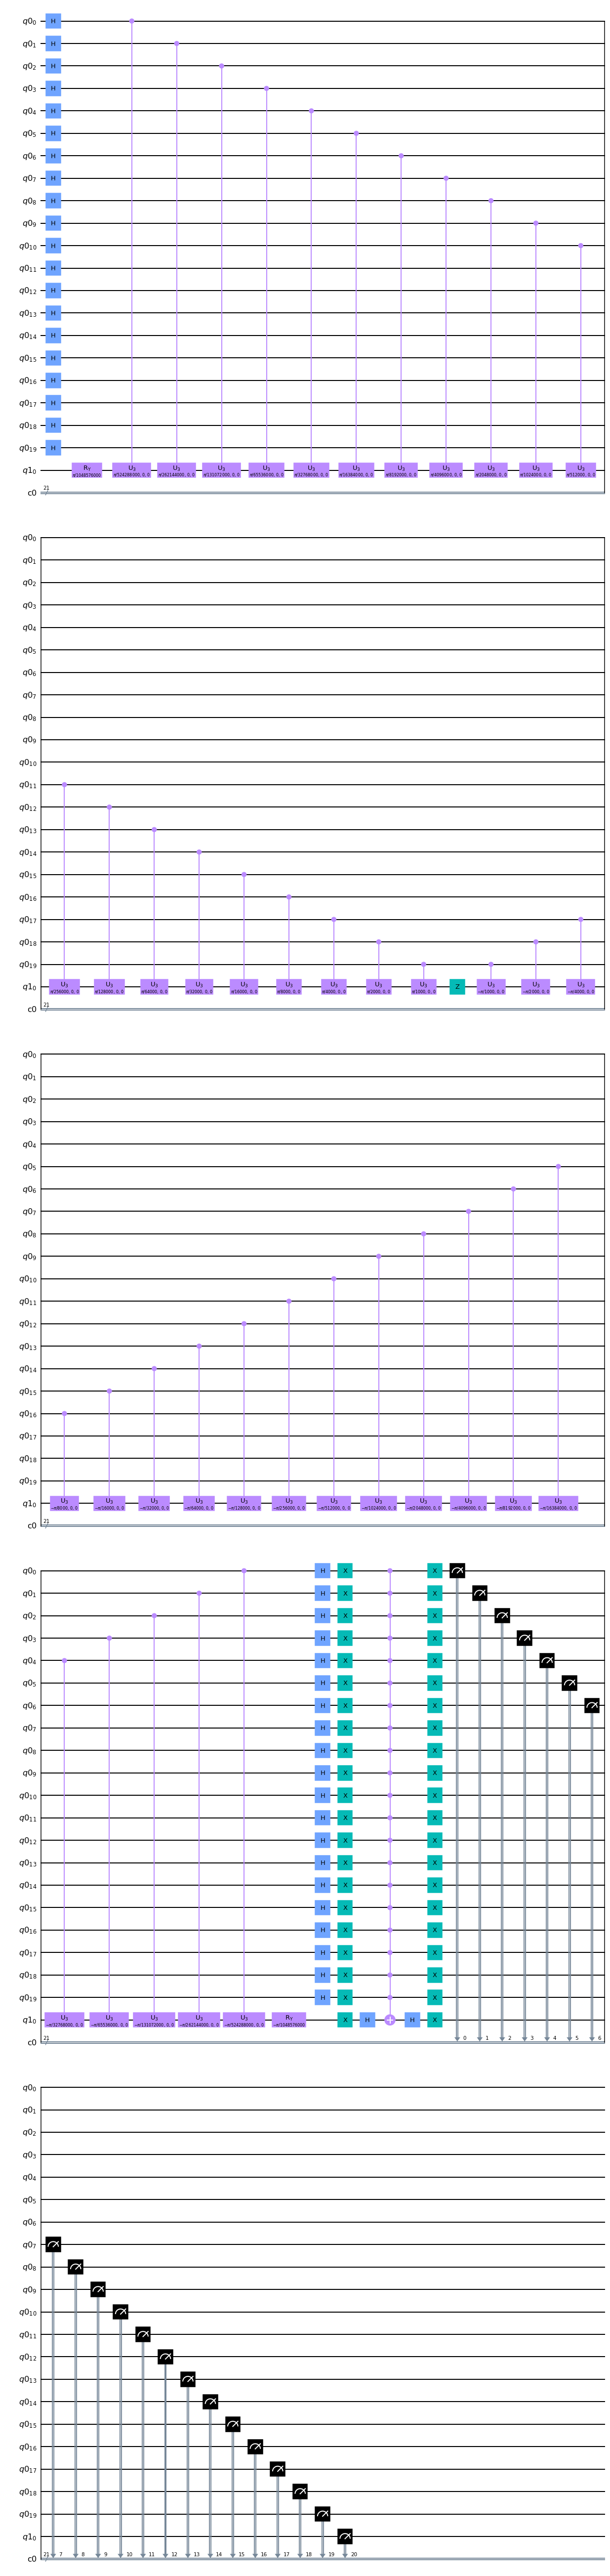

In [5]:
qc_list = create_grover_circuit([1], nbit, b_max)
my_style = {'usepiformat': True, 'cregbundle': True,'compress': True }
qc_list[0].draw(output="mpl", style=my_style, plot_barriers=False )

## Testing the algorithm with simulators

Let us run the algorithm with simulators

In [6]:
#setting the number of shots and Grover operators.

# number_grover_list = [0, 1, 2, 4, 8, 16, 32] # , 64, 128, 256]  # list of number of Grover operators
number_grover_list = [i for i in range(100)]
shots_list = [100] * len(number_grover_list) # list of number of shots
if len(shots_list) != len(number_grover_list):
    raise Exception(
        'The length of shots_list should be equal to the length of number_grover_list.'
    )

backend = Aer.get_backend('qasm_simulator')

In [7]:
noise_model = NoiseModel()
for qi in range(nbit+1):
    if qi >= 0:
        read_err = ReadoutError([[0.990, 0.010],[0.010,0.990]])
        noise_model.add_readout_error(read_err, [qi])

Finally, we can run the algorithm as below: 

In [8]:
qc_list = create_grover_circuit(number_grover_list, nbit,b_max)  # list of Grover circuits

In [9]:
counts_list = run_grover(qc_list, number_grover_list, shots_list, backend, noise_model=noise_model)  # list of number of grover operators

0 th round with 0 oracles
0.6047549247741699 s
1 th round with 1 oracles
0.12690997123718262 s
2 th round with 2 oracles
0.2201368808746338 s
3 th round with 3 oracles
0.31502604484558105 s
4 th round with 4 oracles
0.4014310836791992 s
5 th round with 5 oracles
0.4804668426513672 s
6 th round with 6 oracles
0.6258459091186523 s
7 th round with 7 oracles
0.7599170207977295 s
8 th round with 8 oracles
0.954901933670044 s
9 th round with 9 oracles
1.0497090816497803 s
10 th round with 10 oracles
1.0807850360870361 s
11 th round with 11 oracles
1.018413782119751 s
12 th round with 12 oracles
1.1315851211547852 s
13 th round with 13 oracles
1.3335740566253662 s
14 th round with 14 oracles
1.4537646770477295 s
15 th round with 15 oracles
1.8612122535705566 s
16 th round with 16 oracles
2.344896078109741 s
17 th round with 17 oracles
1.8330681324005127 s
18 th round with 18 oracles
1.9127161502838135 s
19 th round with 19 oracles
1.869227647781372 s
20 th round with 20 oracles
1.907080173492

In [ ]:
import pickle
with open("raw_result_20_001_001_piover1000.pkl", "wb") as f:
    pickle.dump(counts_list, f)

In [10]:
import pickle
with open("raw_result_20_001_001_piover1000.pkl", "rb")as f:
    counts_list = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'raw_result_20_001_001_piover1000.pkl'

In [9]:
hit_list = make_hit_list(counts_list)
print(hit_list)

[77, 84, 77, 80, 78, 78, 73, 72, 71, 63, 76, 68, 65, 66, 67, 56, 53, 48, 47, 47, 46, 43, 37, 40, 34, 35, 27, 26, 13, 21, 19, 17, 7, 12, 10, 8, 7, 6, 5, 4, 0, 3, 1, 0, 0, 1, 0, 4, 6, 4, 7, 10, 8, 17, 13, 13, 14, 14, 33, 32, 16, 24, 24, 40, 39, 49, 36, 46, 52, 54, 51, 56, 64, 64, 63, 72, 67, 78, 70, 68, 73, 79, 76, 83, 69, 81, 81, 79, 81, 83, 82, 79, 73, 73, 76, 68, 75, 70, 67, 61]


In [10]:
shots = 8192
qr = QuantumRegister(nbit+1)
mit_pattern = [[i] for i in range(nbit+1)]
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
job = execute(meas_calibs, backend=Aer.get_backend('qasm_simulator'), shots=shots, noise_model=noise_model)
cal_results = job.result()
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)

In [11]:
meas_filter = InvSLM0SGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_S_lm_0_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    x_tilde_S_lm_0_list.append(x_tilde)
mit_hit_S_lm_0_list = make_hit_list(x_tilde_S_lm_0_list)
print(mit_hit_S_lm_0_list)

Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0925908172855974
sum of mitigated probability vector x_hat_s: 1.0925907386444522
number of positive values:  18
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.1376152593065993
sum of mitigated probability vector x_hat_s: 1.137615212689892
number of positive values:  11
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.1128884267915518
sum of mitigated probability vector x_hat_s: 1.1128883546995618
number of positive values:  17
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.1193676666924393
sum of mitigated probability vector x_hat_s: 1.1193675906975717
number of positive values:  16
main process: Done!
Restriction to labels of y + Lagrange Mul

sum of mitigated probability vector x_s: 1.1472579814664488
sum of mitigated probability vector x_hat_s: 1.1472578816238652
number of positive values:  20
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.1622948493275795
sum of mitigated probability vector x_hat_s: 1.1622947483421848
number of positive values:  20
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.1440546452800706
sum of mitigated probability vector x_hat_s: 1.1440545602471757
number of positive values:  17
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.15795744169778
sum of mitigated probability vector x_hat_s: 1.1579573610868865
number of positive values:  16
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1

sum of mitigated probability vector x_s: 1.138335028177968
sum of mitigated probability vector x_hat_s: 1.1383349441899817
number of positive values:  18
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.1497784269841025
sum of mitigated probability vector x_hat_s: 1.1497783534064563
number of positive values:  16
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.1323535233448183
sum of mitigated probability vector x_hat_s: 1.1323534364621635
number of positive values:  19
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.1562338981512492
sum of mitigated probability vector x_hat_s: 1.156233848337352
number of positive values:  11
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1

In [12]:
meas_filter = MooneyEtal(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_mooney_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts, threshold=1/100)
    x_tilde_mooney_list.append(x_tilde)
mit_hit_mooney_list = make_hit_list(x_tilde_mooney_list)
print(mit_hit_mooney_list)

The heuristcs by Mooney et al. + SGS algorithm
{65536: 0.0155673094316203, 524296: 0.012101077713094483, 64: 0.014216281830128501, 4: 0.015405054344510463, 16: 0.014924879579668622, 0: 0.9544723255248813, 16384: 0.014852463044152558, 524288: 0.0125446437715159, 3072: 0.012280501282183822}
sum of counts: 1.0663645365217562
number of positive values:  9
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{4096: 0.027967869794947517, 262144: 0.014176107290689102, 65536: 0.014712798157841796, 16: 0.014021502221298847, 512: 0.013911029958823273, 0: 1.0420251321397678}
sum of counts: 1.1268144395633684
number of positive values:  6
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{128: 0.016057028013442554, 1: 0.015554083507596307, 4: 0.027820239104479928, 33280: 0.01217112499169417, 262144: 0.015070492927632581, 131072: 0.01569256833958635, 131136: 0.012151220087876467, 32768: 0.01494542187081333, 0: 0.9545893950470927}
sum of counts: 1.0840515738902143
numb

{64: 0.014487334521166063, 1: 0.01579637328322484, 1310720: 0.024177876194142786, 524288: 0.012837303202039345, 1048576: 0.05132152604348438, 1572864: 0.011437851960900244, 16384: 0.015108621595037081, 131072: 0.016045534230529318, 1048832: 0.01171837815853706, 1024: 0.027822825055716878, 0: 0.9296931053656778}
sum of counts: 1.130446729610456
number of positive values:  11
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{512: 0.015735426717828765, 128: 0.016856378426907192, 1441792: 0.012190594264877215, 1310720: 0.01087838727445238, 1179648: 0.010908277818075343, 64: 0.015172605839722587, 4096: 0.017080928378034255, 1180672: 0.012295633611816266, 1048576: 0.1265911862856284, 524288: 0.02611664026143488, 0: 0.8669014688513453}
sum of counts: 1.1307275277301225
number of positive values:  11
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{1310720: 0.01037640824925385, 1048608: 0.022125360566058103, 32: 0.04014464819453071, 66048: 0.012301570485530

In [19]:
import pickle
with open("hit_list_20_001_001.pkl", "wb") as f:
    pickle.dump(hit_list, f)

In [13]:
import pickle
with open("mit_hit_S_lm_0_list_20_001_001.pkl", "wb") as f:
    pickle.dump(mit_hit_S_lm_0_list, f)

In [14]:
import pickle
with open("mit_hit_mooney100_list_20_001_001.pkl", "wb") as f:
    pickle.dump(mit_hit_mooney_list, f)

In [ ]:
with open("hit_list_20_001_001.pkl", "rb") as f:
    hit_list = pickle.load(f)
with open("mit_hit_S_lm_0_list_20_001_001.pkl", "rb") as f:
    mit_hit_S_lm_0_list = pickle.load(f)
with open("mit_hit_mooney100_list_20_001_001.pkl", "rb") as f:
    mit_hit_mooney_list = pickle.load(f)

Text(0, 0.5, 'number of shots for $|00...0>$')

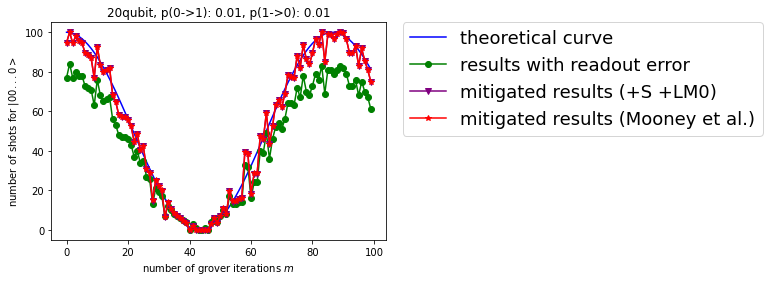

In [15]:
divide = 100
number_grover_list = [i for i in range(100)]
plt.plot(np.linspace(0,number_grover_list[-1], divide), 100 * np.cos(2 * np.linspace(0,number_grover_list[-1], divide) * np.arccos(np.sqrt(discretizedResult))) ** 2, label="theoretical curve", color="blue")
plt.plot(number_grover_list, hit_list, marker="o", label="results with readout error", color="green")
plt.plot(number_grover_list, mit_hit_S_lm_0_list, marker="v", label="mitigated results (+S +LM0)", color="purple")
plt.plot(number_grover_list, mit_hit_mooney_list, marker="*", label="mitigated results (Mooney et al.)", color="red")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.title("20qubit, p(0->1): 0.01, p(1->0): 0.01")
plt.xlabel("number of grover iterations $m$")
plt.ylabel("number of shots for $|00...0>$")

In [18]:
sin_hit_list = [100 - h for h in hit_list]
sin_mit_hit_S_lm_0_list = [100 - h for h in mit_hit_S_lm_0_list]
sin_mit_hit_mooney_list = [100 - h for h in mit_hit_mooney_list]

thetaCandidate_list = calculate_theta(
    sin_hit_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_S_lm_0_list = calculate_theta(
    sin_mit_hit_S_lm_0_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_mooney_list = calculate_theta(
    sin_mit_hit_mooney_list, number_grover_list, shots_list)  # list of estimated theta values

error_list = np.abs(np.sin(thetaCandidate_list)**2 - discretizedResult)  # list of estimation errors
error_mit_S_lm_0_list = np.abs(np.sin(thetaCandidate_mit_S_lm_0_list)**2 - discretizedResult)  # list of estimation errors
error_mit_mooney_list = np.abs(np.sin(thetaCandidate_mit_mooney_list)**2 - discretizedResult)  # list of estimation errors
OracleCall_list = []  # list of number of oracle calls
ErrorCramérRao_list = []  # list of Cramér-Rao lower bound
for i in range(len(number_grover_list)):
    OracleCall_list.append(
        CalcNumberOracleCalls(i, shots_list, number_grover_list))
    ErrorCramérRao_list.append(
        CalcErrorCramérRao(i, shots_list, discretizedResult, number_grover_list))

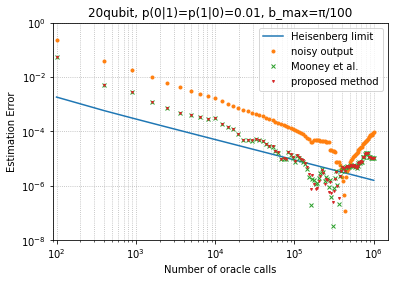

In [20]:
plt.clf()
p = plt.loglog( OracleCall_list, ErrorCramérRao_list)
p0 = plt.loglog( OracleCall_list, error_list, 'o', markersize=3)
p2 = plt.loglog( OracleCall_list, error_mit_mooney_list, 'x', color='C2', markersize=4)
p3 = plt.loglog( OracleCall_list, error_mit_S_lm_0_list, 'v', color='C3', markersize=2)

plt.title("20qubit, p(0|1)=p(1|0)=0.01, b_max=π/100")
plt.xlim(OracleCall_list[0]*0.9, OracleCall_list[-1]*1.5)
plt.xlabel("Number of oracle calls")
plt.ylim(0.00000001, 1)
plt.ylabel("Estimation Error")
plt.grid(True, which="both", ls="dotted")
plt.legend((p[0], p0[0], p2[0], p3[0]), ("Heisenberg limit", "noisy output", "Mooney et al.", "proposed method"))
plt.show()